## Objective

Xây dựng một mô hình dự đoán khách hàng tại Ngân hàng Đa quốc gia ABC sẽ rời bỏ hay tiếp tục sử dụng dịch vụ.

Mô hình này sẽ được team Strategy sử dụng để ước lượng số lượng khách hàng rời bỏ và lên các phương án cải thiện.


## Dataset & Description

Link dataset:

https://drive.google.com/file/d/1fFqLRizk_W9WCtRVKusQclwDU_5KaUg7/view?usp=drive_link

Đây là dữ liệu khách hàng của các khách hàng tại Ngân hàng Đa quốc gia ABC có phát sinh giao dịch

## Result

File source code xây dựng mô hình có dạng `ipynb`.

# Solution
Trước hết ta phân tích đề bài và làm rõ các điểm chính:
  - Tài nguyên: dựa vào data/thông tin gì, lấy ở đâu, có ý nghĩa gì, có thêm/bớt được hay không?
  > dataset đầu bài, trong lĩnh vực NH, dữ liệu không thể thêm/bớt.
  - Mục tiêu: kết quả mong muốn cuối cùng là gì?
  > model có khả năng dự báo KH ngưng sử dụng Dv > bài toán Classification.

  > File nộp lưu định dạng `.ipynb`.
  - Đối tượng: kết quả dành cho ai?
  > dành cho Team Strategy > chỉ cần Model dự báo tốt nhất dưới dạng Yes/No, không cần con số xác suất chính xác.
  - Phương tiện: sử dụng những công cụ gì?
  > các thư viện panda, sklearn, matplotlib, seaborn ...
  - Phương pháp: sử dụng các phương pháp gì?
  > Các dataset dạng này hay xảy ra Imbalance nên cần chú ý xem xét các chỉ số khác ngoài Accuracy (Vd F1 score) đồng thời cân nhắc các cách Resampling phù hợp (tham khảo: [SMOTE Variations](https://www.kdnuggets.com/2023/01/7-smote-variations-oversampling.html)) và triển khai nhiều model để có cái nhìn toàn diện nhất có thể.

  > Bên cạnh đó cũng xem xét khả năng chọn Feature phù hợp thay vì Resampling để so sánh (tham khảo: [Are unbalanced datasets problematic?](https://stats.stackexchange.com/questions/357466/are-unbalanced-datasets-problematic-and-how-does-oversampling-purport-to-he)).

Sau đó mới đưa ra phương hướng xử lý như sau:

1/ Thực hiện EDA tìm hiểu dữ liệu.

2/ Đưa ra Hypothesis về sự tương quan giữa Features và Target.

3/ Tiến hành Preprocessing.

4/ Dựa vào Hypothesis tiến hành Modeling theo 2 cách:

* Thực hiện Feature Selection bằng method `Corr` chọn ra các Feature tốt nhất (ảnh hưởng nhất) để thực hiện Modeling (thay vì dùng tất cả và chấp nhận Data Imbalance). Sau đó thực thiện Modeling với nhiều Model khác nhau để tìm ra Model phù hợp nhất.

* Thực hiện Resampling Data với tất cả các Feature có liên quan với Target theo 3 cách khác nhau (Under, Over hay kết hợp). Sau đó thực thiện Modeling với nhiều Model khác nhau để tìm ra cách Resampling và Model phù hợp nhất.

5/ So sánh các kết quả thu được theo 2 cách trên để đưa ra nhận xét và đề xuất.

## EDA

### Import Library

In [ ]:
# import panda để xử lý data
import pandas as pd

# import các lib để tạo visual
import matplotlib.pyplot as plt
import seaborn as sns

# import lib để download file vào collab và xử lý file zip
import gdown
import zipfile

### Load Data

In [ ]:
link = 'https://drive.google.com/file/d/1fFqLRizk_W9WCtRVKusQclwDU_5KaUg7/view'
path = 'https://drive.google.com/uc?id='+link.split('/')[-2]

# download file lên collab
file = gdown.download(path)

# tạo object là file zip để thao tác
zf = zipfile.ZipFile(file)

# mở file 'Data_Quest_2.csv' trong số 2 file con của file zip và load vào dataframe
df = pd.read_csv(zf.open('Data_Quest_2.csv'))

# xem 10 dòng đầu tiên trong dataset
df.head(10)

Downloading...
From: https://drive.google.com/uc?id=1fFqLRizk_W9WCtRVKusQclwDU_5KaUg7
To: /content/Data_Quest_2.zip
100%|██████████| 194k/194k [00:00<00:00, 58.9MB/s]


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,15592531,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,15656148,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,15792365,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,15592389,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [ ]:
# xem 10 dòng ngẫu nhiên trong dataset
df.sample(10)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
3234,15664907,527,France,Male,47,1,0.00,1,1,0,21312.16,1
8912,15637354,623,France,Female,24,7,148167.83,2,1,1,109470.34,0
5325,15599126,529,France,Female,43,0,123815.86,1,1,1,78463.99,1
8532,15780805,585,France,Female,35,2,0.00,2,1,0,98621.04,1
3954,15758755,729,France,Female,34,9,132121.71,1,0,1,105409.31,0
6955,15697042,738,Spain,Male,35,8,127290.61,1,1,0,16081.62,0
343,15684484,543,France,Male,22,8,0.00,2,0,0,127587.22,0
1702,15713644,686,Spain,Male,22,5,0.00,2,1,0,158974.45,0
5499,15649078,850,Germany,Female,27,8,111837.78,2,1,1,110805.79,0
5905,15731519,511,France,Female,30,5,0.00,2,1,0,143994.86,0


In [ ]:
display(df.describe())
display(df.describe(include = 'O'))

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


,country,gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


In [ ]:
# xem các thông tin chung
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [ ]:
# kiểm tra null
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

**Nhận xét:**

* Dataset có 10000 hàng và 12 cột.
* Cột `customer_id` không mang tính phân loại > drop.
* Có 2 cột `gender` và `country` dạng text > encoding.
* Không có cột nào bị null.

## Make Hypothesis

### Univariate Analysis
Số KH rời bỏ ít hơn nhiều so với số KH còn sử dụng dịch vụ?

<Axes: xlabel='churn', ylabel='count'>

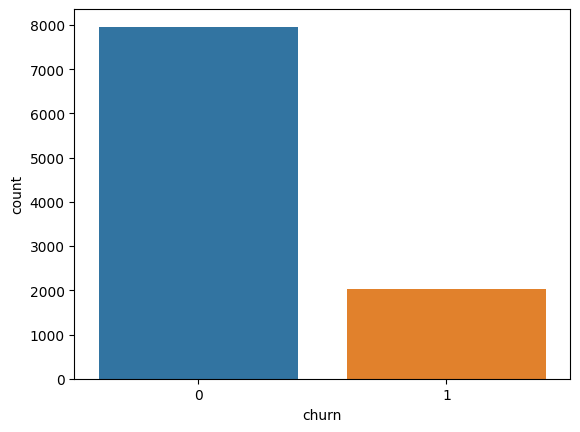

In [ ]:
sns.countplot(x = 'churn', data = df)

**Nhận xét:**

* Data bị imbalance nên cần xử lý trước khi thực hiện Modeling.

### Bivariate Analysis
1/ Số KH nữ rời bỏ nhiều hơn so với số KH nam?

2/ Số KH rời bỏ ở các QG khác nhau là tương tự nhau?

<Axes: xlabel='churn', ylabel='count'>

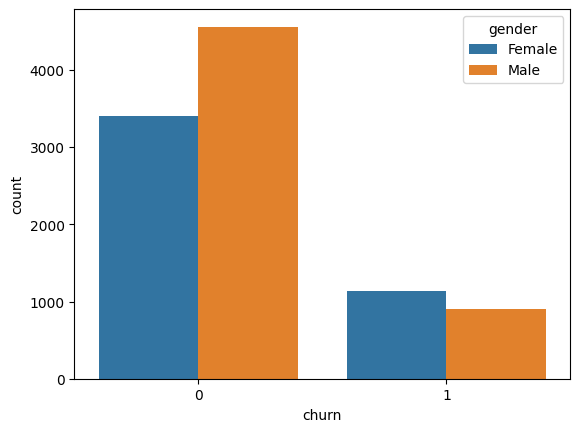

In [ ]:
sns.countplot(x = 'churn', hue = 'gender', data = df)

**Nhận xét:**
* Số lượng KH Nam (Male) sử dụng Dv của NH nhiều hơn Nữ (Female).

* Số lượng KH Nữ rời bỏ nhiều hơn Nam.

<Axes: xlabel='churn', ylabel='count'>

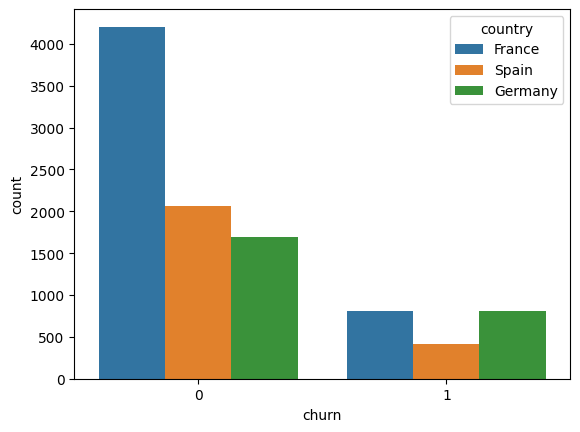

In [ ]:
sns.countplot(x = 'churn', hue = 'country', data = df)

**Nhận xét:**
* Nước Đức (Germany) có tỷ lệ KH rời đi nhiều nhất so với Pháp (France) và Tây Ban Nha (Spain).

### Correlation Analysis
Phân tích tương quan giữa các cột dạng số còn lại trong dataset.

<ipython-input-10-8f63966f739d>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".1f")


<Axes: >

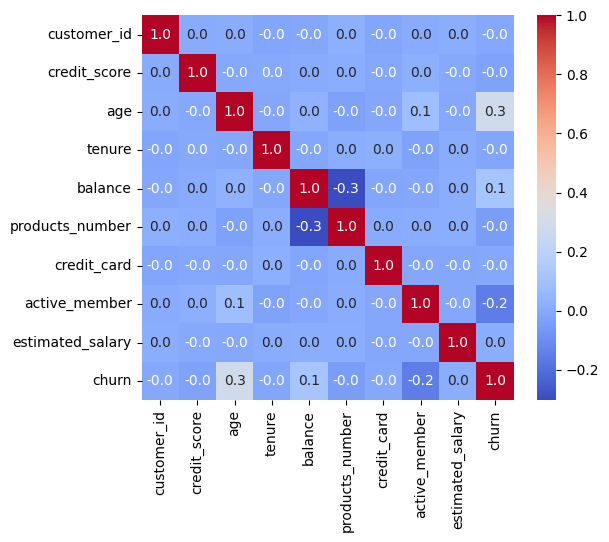

In [ ]:
#  chỉnh lại size hình vẽ
plt.figure(figsize=(6,5))

# thực hiện vẽ heatmap có hiển thị số (2 chữ số thập phân) với màu 'coolwarm'
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".1f")

**Nhận xét:**
* Hai cột `Age` và `Balance` có ảnh hưởng tới `churn`.
* Cột `active_member` có tương quan âm với `churn`.
> Tiến hành modeling chỉ sử dụng 3 cột này để so sánh hiệu quả với khi dùng tất cả các cột.

## Preprocessing

### Remove duplicates
Loại bỏ các hàng bị trùng lặp nếu có.

In [ ]:
# kiểm tra dữ liệu có trùng lặp hay không
df[df.duplicated()].shape

(0, 12)

Không có dữ liệu bị trùng lặp nên bỏ qua bước này.

### Remove nonuse column
Loại bỏ các cột không dùng.

In [ ]:
# bỏ cột 'customer_id' khỏi data frame
df = df.drop(columns = ['customer_id'])

# kiểm tra
df.columns

Index(['credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary',
       'churn'],
      dtype='object')

### Handle null
Xử lý null trong dataset:
* Nếu cột bị null quá nhiều -> bỏ cột.
* Nếu cột bị null ít -> fill NaN (bằng Mean/Median cho dạng số hay Mode cho text).

Không có null trong dataset nên bỏ qua bước này.

### Encoding
Chuyển data dạng text sang dạng số:
- One Hot Encoding:
  - Khoảng cách giữa các cặp giá trị là như nhau.
  - Áp dụng khi số lượng giá trị distinct nhỏ.
> Vd: Táo, Cam, Ổi.
- Ordinal Encoding:
  - Khoảng cách giữa các cặp giá trị là khác nhau.
  - Áp dụng khi số lượng giá trị distinct lớn.
> Vd: Fresher, Junior, Senior, Manager.

Do chỉ có 2 cột text `country` và `gender` kèm theo số lượng giá trị distinct mỗi cột ít (3 và 2) nên sử dụng One Hot Encoding.

In [ ]:
# thực hiện One Hot Encoder
df = pd.get_dummies(df)
# kiểm tra
df.sample(10)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,country_Germany,country_Spain,gender_Female,gender_Male
3202,564,33,4,135946.26,1,1,0,63170.00,0,1,0,0,1,0
7435,610,50,5,130554.51,3,1,0,184758.17,1,0,0,1,1,0
3906,597,44,8,78128.13,2,0,1,109153.04,0,1,0,0,0,1
7525,580,35,9,121355.19,1,0,1,35671.45,0,0,1,0,0,1
5469,723,21,4,0.00,2,0,0,24847.02,0,1,0,0,0,1
3983,626,44,2,0.00,1,0,1,173117.22,1,1,0,0,1,0
8016,569,41,2,0.00,2,1,0,134272.57,0,0,0,1,0,1
257,671,34,6,37266.67,2,0,0,156917.12,0,0,1,0,1,0
3700,678,22,6,118064.93,2,1,1,195424.01,0,1,0,0,1,0
3111,623,42,1,149332.48,2,1,0,100834.22,0,0,1,0,0,1


## Modeling
Tiến hành:

- Xác định Feature-Target.
- Chia các tập Train-Test.
- Thực hiện Feature Scaling nếu cần.
- Thực hiện xử lý Imbalanced Data nếu cần.
- Tạo và train Model.
- Đánh giá Model.

### Define Feature - Target

Ở đây tiến hành tạo 2 cặp Feature - Target như đã đề cập ở phần Correlation Analysis:
- X, y với X là tất cả các Feature.
- x, y với x gồm 3 cột `age`, `balance`, `active_member`.
- y là `churn`.

In [ ]:
# tạo X với tất cả Feature
X = df.drop(columns = 'churn')

# tạo x với 3 Feature
x = df[['age', 'balance', 'active_member']]

#  tạo y
y = df['churn']

### Train - Test Split

Từ 2 cặp (X,y) và (x,y) sẽ tiến hành split thành 2 cặp (X_train, X_test, Y_train, Y_test) và (x_train, x_test, y_train, y_test).

In [ ]:
from sklearn.model_selection import train_test_split

# chia train-test cho (X,y)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=6)

In [ ]:
# chia train-test cho (x,y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

### Scale Data

Bước này giúp model xử lý nhanh, không thiên vị và ổn định.

Có 2 kiểu thường gặp:
- Standardisation.
- Max-Min Normalization.

Do scale giữa các Feature chênh lệch lớn (Vd `Age` < 92 và `Balance` > 76,485) nên sử dụng Standard thay vì Min-Max scaler.

In [ ]:
# import module và khởi tạo Scaler
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

# fit scaler cho X (Full Feature)
std_scaler.fit(X_train)
X_train_scale = std_scaler.transform(X_train)
X_test_scale = std_scaler.transform(X_test)

In [ ]:
# fit scaler cho x (3 Feature)
std_scaler.fit(x_train)
x_train_scale = std_scaler.transform(x_train)
x_test_scale = std_scaler.transform(x_test)

### Handle Imbalanced Data
Thực hiện xử lý Imbalanced Data bằng Resampling nếu cần.
Các cách Resampling thường gặp là:
- Oversampling.
> Dễ gây ra tình trạng overfit và tạo ra dữ liệu ảo ảnh hưởng đến tính chính xác của model.
- Undersampling.
> Gây ra thất thoát dữ liệu và lãng phí tài nguyên.
- Kết hợp giữa oversampling và undersampling.
> Kết hợp cả ưu - nhược điểm của 2 cái trên, nhưng nhiều phiên bản và phức tạp hơn.

Ở đây áp dụng cách Resampling kết hợp giữa oversampling và undersampling là SMOTE-ENN.

So với các phiên bản còn lại thì phiên bản này tương đối cân bằng giữa việc gia tăng dữ liệu ảo của class Thiểu số ít nhất và thất thoát dữ liệu của class Đa số (tham khảo: [Link](https://www.kdnuggets.com/2023/01/7-smote-variations-oversampling.html)).

In [ ]:
# import module SMOTEENN
from imblearn.combine import SMOTEENN

# khởi tạo model resampling
enn = SMOTEENN(random_state=10)

# resample cặp X_train, Y_train (không áp dụng cho X,y gốc tránh leak data và overfit)
X_trn_scl_enn, Y_trn_enn = enn.fit_resample(X_train_scale, Y_train)

# kiểm tra
print('Ban đầu:\n',Y_train.value_counts(), '\n')
print('Sau khi rebalance với ENN:\n',Y_trn_enn.value_counts())

Ban đầu:
 0    6369
1    1631
Name: churn, dtype: int64 

Sau khi rebalance với ENN:
 1    5380
0    4210
Name: churn, dtype: int64


### Build - Train - Evaluate
Thực hiện việc chuẩn bị (Prepare) và triển khai (Deploy) các model.

Từ yêu cầu đề bài xác định ra bài toán cần xử lý dạng Classification -> lựa chọn các model như `Logistic Regression, Naive Bayes, Decision Tree, Random Forest, KNN, SVM`.

Số lượng model sử dụng khá nhiều (**6**) đồng thời cần tính toán và đánh giá cho 2 cặp data là (X,y) và (x,y) nên nhu cầu thực hiện quá trình **Build - Train - Evaluate** (*Xây dựng - Huấn luyện - Đánh giá*) **hàng loạt** (dynamically) là cần thiết.

#### Prepare
Thực hiện các công việc chuẩn bị:

- Import thư viện hỗ trợ
- Tạo từ điển ML-model để sử dụng và tái sử dụng về sau.
- Tạo biến chứa loại bài toán.
- Tạo danh sách các models sử dụng.
- Tạo hàm thực hiện việc **Build - Train - Evaluate** hàng loạt.

In [ ]:
# import module hỗ trợ import các module khác dưới dạng text
import importlib

# tạo từ điển lưu trữ thông tin các model Machine Learning đã từng học để tái sử dụng
ML_model_dict = {'Linear Regression' : {'module':'sklearn.linear_model', 'Regression':'LinearRegression'},
                 'Logistic Regression' : {'module':'sklearn.linear_model', 'Classification':'LogisticRegression'},
                 'Naive Bayes' : {'module':'sklearn.naive_bayes', 'Classification':'GaussianNB'},
                 'Decision Tree' : {'module':'sklearn.tree', 'Classification':'DecisionTreeClassifier', 'Regression':'DecisionTreeRegressor'},
                 'Random Forest' : {'module':'sklearn.ensemble', 'Classification':'RandomForestClassifier', 'Regression':'RandomForestRegressor'},
                 'KNN' : {'module':'sklearn.neighbors', 'Classification':'KNeighborsClassifier', 'Regression':'KNeighborsRegressor'},
                 'SVM' : {'module':'sklearn.svm', 'Classification':'SVC', 'Regression':'SVR'}
                 }

In [ ]:
# tạo biến chứa loại bài toán mà model ML xử lý theo yêu cầu đầu bài
ML_problem_type = 'Classification'

# tạo danh sách model sẽ sử dụng trong bài
model_list = ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'KNN', 'SVM']

# khởi tạo các list để lưu thông tin tập feature X và model sử dụng cùng các chỉ số đánh giá trước khi lặp
ftr = [] # tập Feature đang dùng
mdl = [] # tên model đang dùng
mtr =[] # metric đánh giá
scr = [] # score của metric đánh giá

In [ ]:
# tạo hàm triển khai model hàng loạt với 5 input là: X (tập Feature sử dụng để split), X_train, X_test, y_train, y_test
def deploy_multi_model(X, X_train, X_test, y_train, y_test):

  # dùng vòng lặp for thực hiện chuỗi công việc "Xây dựng, Huấn luyện, Đánh giá" hàng loạt cho các model trong danh sách
  for md in model_list:

    # Xây dựng model
    module_name = ML_model_dict[md]['module'] # lấy ra tên module gốc từ từ điển "ML_model_dict"
    module = importlib.import_module(module_name) # import module này bằng method "import_module" của "importlib" qua tham chiếu là tên
    model_name = ML_model_dict[md][ML_problem_type] # lấy ra tên của model cần dùng dựa vào tên model và kiểu bài toán
    get_model = getattr(module, model_name) # import model bằng method "getattr" của Python
    model = get_model() # khởi tạo model
    print('\nModel la', model)

    # Huấn luyện model
    model.fit(X_train, y_train)

    # Đánh giá model

    y_pred = model.predict(X_test) # dự đoán y từ tập X_test

      # đánh giá cho bài toán Classification
    if ML_problem_type == 'Classification':
      from sklearn.metrics import confusion_matrix, classification_report ,accuracy_score, precision_score, recall_score, f1_score

      # tạo và vẽ heatmap cho confusion matrix
      plt.figure(figsize=(4,3))
      cm = confusion_matrix(y_test, y_pred)
      ax = plt.subplot()
      sns.heatmap(cm, annot = True, fmt = "g", ax = ax)
      ax.set_xlabel("Predicted Label")
      ax.set_ylabel("Actual Label")
      ax.set_title("Confusion Matrix")
      plt.show()

      # tính các chỉ số accuracy_score, precision_score, recall_score, f1_score
      s1 = accuracy_score(y_test, y_pred) # gán s
      s2 = precision_score(y_test, y_pred)
      s3 = recall_score(y_test, y_pred)
      s4 = f1_score(y_test, y_pred)

      # lưu thông tin tập feature X và model sử dụng cùng các chỉ số vào 4 list đã tạo ban đầu
      for i in range(4):
          ftr.append(X)
          mdl.append(md)
      mtr.extend(['accuracy','precision','recall','f1_score'])
      scr.extend([s1,s2,s3,s4])

      # in ra báo cáo tổng hợp các chỉ số đánh giá phân loại
      print(classification_report(y_test, y_pred))
      print('xxxxxxxxxxxxxxxxxxxxxxxxxxx'*2) # tạo ranh giới phân biệt

#################### phần này không nằm trong phạm vi đề bài, tuy nhiên HV muốn làm một cách tổng quát nhất có thể

    else: # cho trường hợp khác tức "Regression"
      from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

      # tính các chỉ số đánh giá
      r2_score = r2_score(y_test, y_pred)
      mae = mean_absolute_error(y_test, y_pred)
      mse = mean_squared_error(y_test, y_pred)

      # in ra các chỉ số
      print('R2_score =',r2_score,'\nMAE =',mae,'\nMSE =',mse)
      print('xxxxxxxxxxxxxxxxxxxxxxxxxxx'*2)
####################################################################################################################

#### Deploy Model
Thực hiện công việc chính **Build - Train - Evaluate** hàng loạt cho 2 cặp (X,y) và (x,y).

Xem lại các cặp giá trị đầu vào từ 2 cặp (X,y) và (x,y) sau khi trải qua các qiá trình SPLIT - SCALE - RESAMPLE (ENN):
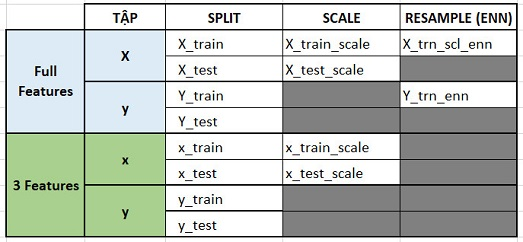

TRUONG HOP 1: VOI FULL FEATURES KET HOP RESAMPLING BANG SMMOTE-ENN


Model la LogisticRegression()


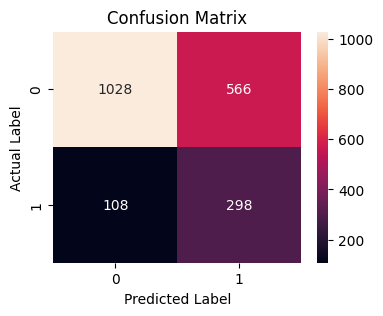

              precision    recall  f1-score   support

           0       0.90      0.64      0.75      1594
           1       0.34      0.73      0.47       406

    accuracy                           0.66      2000
   macro avg       0.62      0.69      0.61      2000
weighted avg       0.79      0.66      0.70      2000

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Model la GaussianNB()


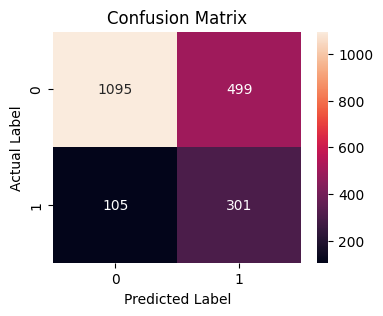

              precision    recall  f1-score   support

           0       0.91      0.69      0.78      1594
           1       0.38      0.74      0.50       406

    accuracy                           0.70      2000
   macro avg       0.64      0.71      0.64      2000
weighted avg       0.80      0.70      0.73      2000

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Model la DecisionTreeClassifier()


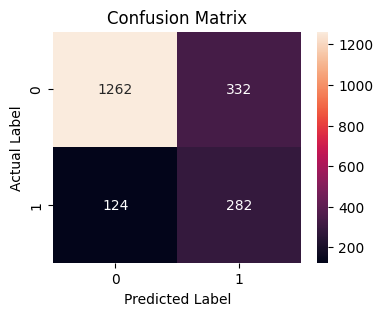

              precision    recall  f1-score   support

           0       0.91      0.79      0.85      1594
           1       0.46      0.69      0.55       406

    accuracy                           0.77      2000
   macro avg       0.68      0.74      0.70      2000
weighted avg       0.82      0.77      0.79      2000

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Model la RandomForestClassifier()


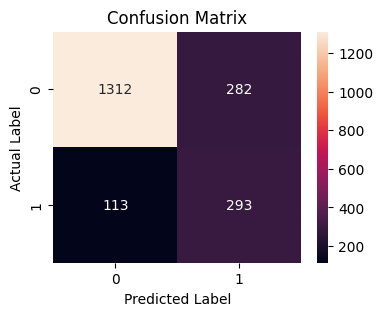

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1594
           1       0.51      0.72      0.60       406

    accuracy                           0.80      2000
   macro avg       0.72      0.77      0.73      2000
weighted avg       0.84      0.80      0.81      2000

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Model la KNeighborsClassifier()


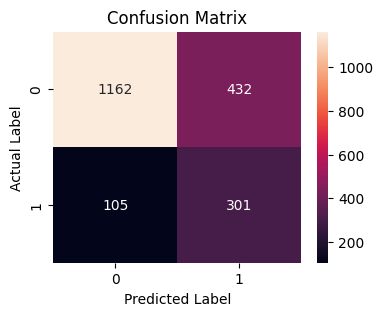

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1594
           1       0.41      0.74      0.53       406

    accuracy                           0.73      2000
   macro avg       0.66      0.74      0.67      2000
weighted avg       0.81      0.73      0.75      2000

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Model la SVC()


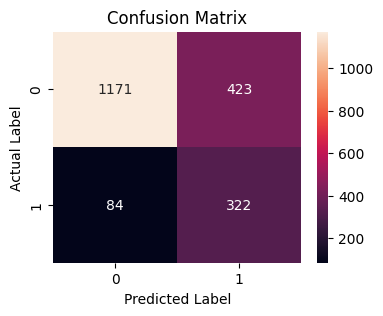

              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1594
           1       0.43      0.79      0.56       406

    accuracy                           0.75      2000
   macro avg       0.68      0.76      0.69      2000
weighted avg       0.83      0.75      0.77      2000

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 

TRUONG HOP 2: VOI 3 FEATURES ANH HUONG NHAT


Model la LogisticRegression()


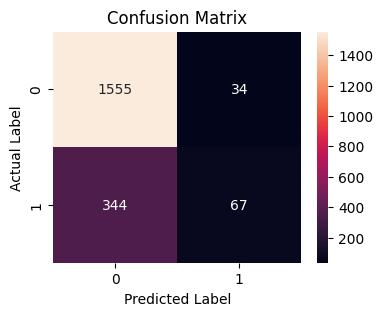

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      1589
           1       0.66      0.16      0.26       411

    accuracy                           0.81      2000
   macro avg       0.74      0.57      0.58      2000
weighted avg       0.79      0.81      0.76      2000

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Model la GaussianNB()


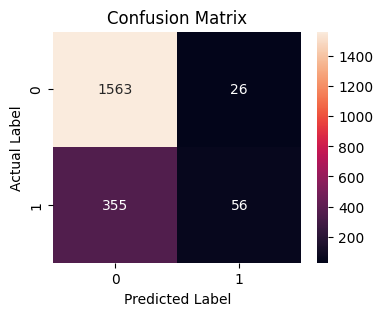

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1589
           1       0.68      0.14      0.23       411

    accuracy                           0.81      2000
   macro avg       0.75      0.56      0.56      2000
weighted avg       0.79      0.81      0.75      2000

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Model la DecisionTreeClassifier()


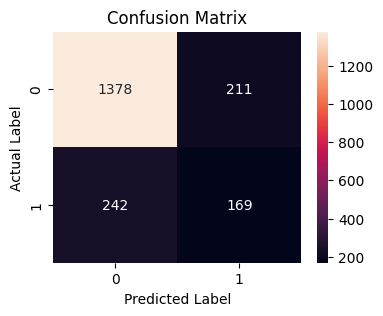

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1589
           1       0.44      0.41      0.43       411

    accuracy                           0.77      2000
   macro avg       0.65      0.64      0.64      2000
weighted avg       0.77      0.77      0.77      2000

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Model la RandomForestClassifier()


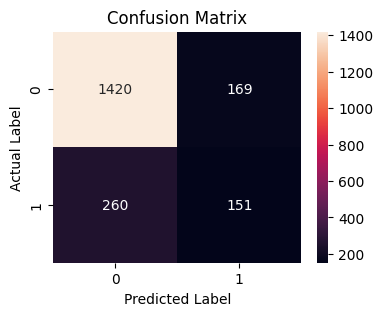

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1589
           1       0.47      0.37      0.41       411

    accuracy                           0.79      2000
   macro avg       0.66      0.63      0.64      2000
weighted avg       0.77      0.79      0.78      2000

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Model la KNeighborsClassifier()


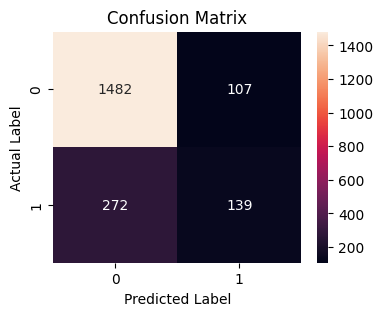

              precision    recall  f1-score   support

           0       0.84      0.93      0.89      1589
           1       0.57      0.34      0.42       411

    accuracy                           0.81      2000
   macro avg       0.70      0.64      0.65      2000
weighted avg       0.79      0.81      0.79      2000

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Model la SVC()


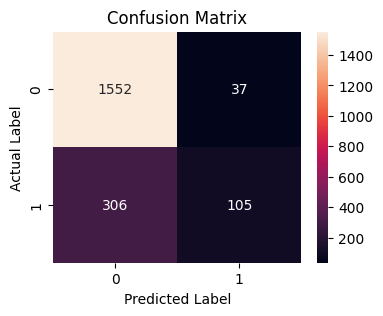

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1589
           1       0.74      0.26      0.38       411

    accuracy                           0.83      2000
   macro avg       0.79      0.62      0.64      2000
weighted avg       0.82      0.83      0.79      2000

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 



In [ ]:
# thực hiện deploy model cho cặp (X,y)
print ('TRUONG HOP 1: VOI FULL FEATURES KET HOP RESAMPLING BANG SMMOTE-ENN\n') # ghi chú
deploy_multi_model('X', X_trn_scl_enn, X_test_scale, Y_trn_enn, Y_test) # gọi hàm phía trên với 5  input như bảng trong hình
print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'*2,'\n') # tạo ranh phân biệt

# thực hiện deploy model cho cặp (x,y)
print ('TRUONG HOP 2: VOI 3 FEATURES ANH HUONG NHAT\n')
deploy_multi_model('x', x_train_scale, x_test_scale, y_train, y_test)
print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'*2,'\n')

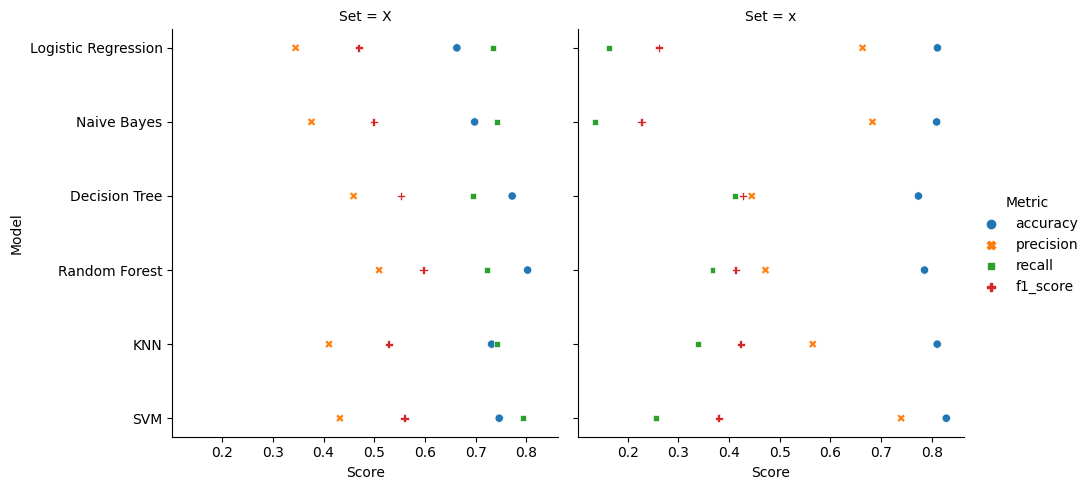

In [ ]:
# tạo dataFrame từ 4 list chứa thông tin kết quả đánh giá các model cuối cùng
model_comparison = pd.DataFrame({'Set':ftr,'Model':mdl,'Metric':mtr,'Score':scr})

# vẽ biểu đồ so sánh dựa trên dataFrame đã tạo
sns.relplot(data=model_comparison, x='Score', y='Model',
            col='Set', hue='Metric', style='Metric')

## Remark & Suggestion
> **NHẬN XÉT**

- Các model sử dụng tập x (3 Features) thường cho ra chỉ số `Accuracy` cao hơn so với khi sử dụng tập X (Full Feature) trừ 2 trường hợp `Decision Tree` và `Random Forest`.
- Các model sử dụng tập x đều cho ra 2 chỉ số `F1_score` và `Recall` thấp hơn nhiều so với khi sử dụng tập X.
- Các model dùng tập X cho ra `Recall` khá tốt (min = 0.69 với `Decision Tree`) và `F1_score` ở mức chấp nhận được (min = 0.47 với `Logistic Regression`).
- Các model dùng tập x cho ra `Recall` rất kém (max = 0.4 với `Decision Tree`) và `F1_score` cũng kém (max = 0.42 với `Decision Tree`).
- **Max** `Accuracy` = **0.83** với `SVC` (tập x), theo sau là 0.81 của **`Random Forest`** (tập X) và một số model khác như `Logistic Regression` (tập x).
- **Max** `F1_score` = **0.61** với  **`Random Forest`** (tập X).
- **Max** `Recall` = **0.79** với `SVC` (tập X), theo sau là 0.74 của **`Random Forest`** (tập X) và một số model khác như `KNN` (tập X).
- `Resampling` giúp model hoạt động tốt hơn so với `Feature Selection` dựa vào Correlation. Tuy nhiên có thể vì correlation giữa 3 Feature `age, balance` và `active_member` với Target `churn` ban đầu khá thấp (< 0.3).

> **ĐỀ XUẤT**

- Trong phạm vi đề bài thì model **`Random Forest`** hoạt động tốt nhất (`F1_score` cao nhất, `Accuracy` và `Recall` cao thứ nhì).
- Tuy nhiên trong điều kiện thực tế vẫn nên áp dụng 2 cách tiếp cận trên (`Resampling` vs `Feature Selection`) song song với xây dựng nhiều model để có cái nhìn tổng quát và toàn diện hơn so với việc chỉ áp dụng mỗi `Resampling` và dùng model **`Random Forest`**.
- Đồng thời sau khi tìm ra model hoạt động khả quan nhất trong từng trường hợp cụ thể (Vd **`Random Forest`** như trong bài) có thể cân nhắc hiệu chỉnh và tối ưu hóa model đó (Vd sử dụng `GridSearchCV` tìm ra tham số tối ưu) để hoàn thiện hơn nữa trong điều kiện Tài chính - Nhân lực - Thời gian cho phép.
